Useful resources used:
https://bolundai0216.github.io/assets/images/control_theory/Feedback%20Linearization%20of%20Double%20Pendulum.pdf
https://physics.umd.edu/hep/drew/numerical_integration/pendulum2.html
https://siliconwit.com/modelling-and-simulation-in-python/simulating-a-swinging-pendulum







1)

Linearised double pendulum using forward euler, strong non-sympletic behaviour - so high lambda used


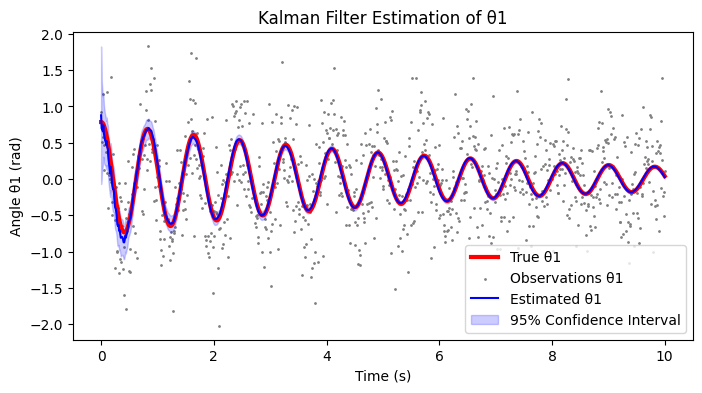

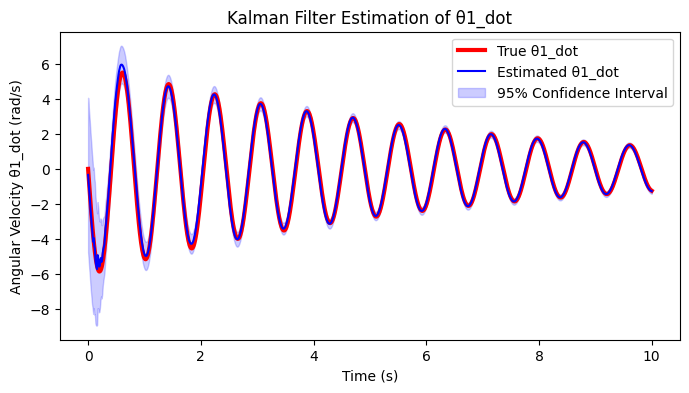

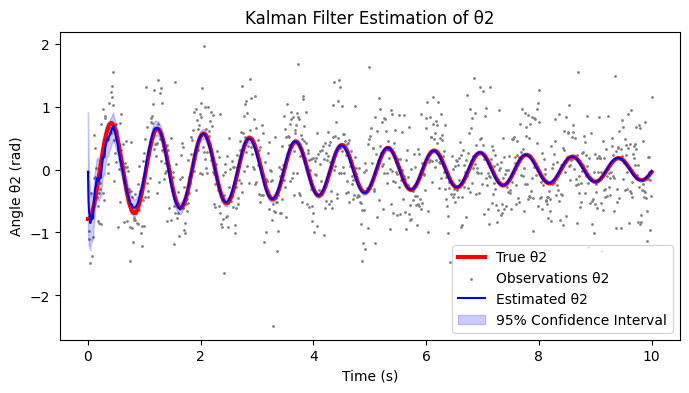

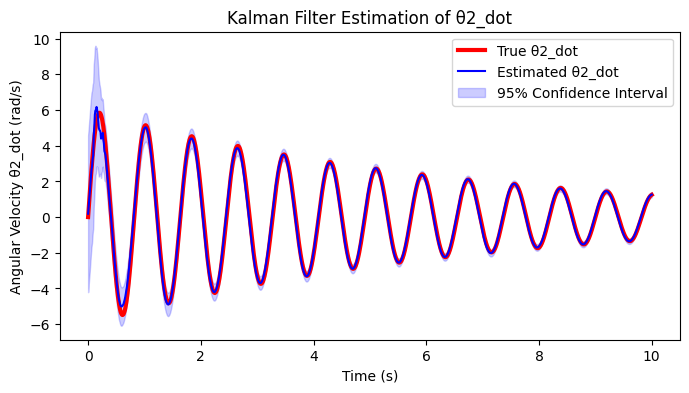

In [24]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from google.colab import files


initial_angle1 = 45
initial_angle2 = -45
t1_0 = initial_angle1 * (jnp.pi / 180)
t2_0 = initial_angle2 * (jnp.pi / 180)
td1_0 = 0
td2_0 = 0


g = 9.81
l = 0.5
m = 1
lam = 0.9  # damping


T = 10
dt = 0.01
N = int(T / dt)


sigma = 0.5    # observation noise standard deviation
q = 0      # process noise variance
R = sigma ** 2 * jnp.eye(2)



A = jnp.array([
    [0, 1, 0, 0],
    [-2 * (g / l), -lam / m, (g / l), 0],
    [0, 0, 0, 1],
    [(g / l), 0, -2 * (g / l), -lam / m]
])

I = jnp.eye(4)
F = I + A * dt


Q = q * dt * jnp.array([
    [0., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 0., 0.],
    [0., 0., 0., 1.]
])


C = jnp.array([
    [1., 0., 0., 0.],
    [0., 0., 1., 0.]
])

x0 = jnp.array([t1_0, td1_0, t2_0, td2_0])


key = random.PRNGKey(0)
key, subkey = random.split(key)
delta_beta1 = random.normal(subkey, shape=(N,)) * jnp.sqrt(q * dt)
key, subkey = random.split(key)
delta_beta2 = random.normal(subkey, shape=(N,)) * jnp.sqrt(q * dt)

w = jnp.stack([
    jnp.zeros(N),
    delta_beta1,
    jnp.zeros(N),
    delta_beta2
], axis=1)


key, subkey = random.split(key)
v = random.normal(subkey, shape=(N + 1, 2)) * sigma

def step(x_prev, inputs):
    w_k, v_k = inputs
    x_k = F @ x_prev + w_k
    y_k = C @ x_k + v_k
    return x_k, (x_k, y_k)

inputs = (w, v[1:])
x_last, (x_states, y_obs) = jax.lax.scan(step, x0, inputs)

x_full = jnp.vstack([x0, x_states])
y_full = jnp.vstack([C @ x0 + v[0], y_obs])

"""Kalman Filter"""

x_est_0 = jnp.array([0., 0., 0., 0.])
P0 = jnp.diag(jnp.array([5., 5., 5., 5.]))

def kalman_step(carry, y_k):
    x_est_prev, P_prev = carry

    x_pred = F @ x_est_prev
    P_pred = F @ P_prev @ F.T + Q

    y_pred = C @ x_pred
    e = y_k - y_pred
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T @ jnp.linalg.inv(S)
    x_est = x_pred + K @ e
    P_est = (jnp.eye(4) - K @ C) @ P_pred
    return (x_est, P_est), (x_est, P_est)

inputs = y_full
carry = (x_est_0, P0)
carry, outputs = jax.lax.scan(kalman_step, carry, inputs)

x_estimates = jnp.vstack([x_est_0, outputs[0]])
P_estimates = jnp.stack([P0] + [P for P in outputs[1]])

time = jnp.linspace(0, T, N+1)


theta1_est = x_estimates[:, 0]
theta1_true = x_full[:, 0]
theta1_std = jnp.sqrt(P_estimates[:, 0, 0])
theta1_upper = theta1_est + 1.96 * theta1_std
theta1_lower = theta1_est - 1.96 * theta1_std

theta1_dot_est = x_estimates[:, 1]
theta1_dot_true = x_full[:, 1]
theta1_dot_std = jnp.sqrt(P_estimates[:, 1, 1])
theta1_dot_upper = theta1_dot_est + 1.96 * theta1_dot_std
theta1_dot_lower = theta1_dot_est - 1.96 * theta1_dot_std

theta2_est = x_estimates[:, 2]
theta2_true = x_full[:, 2]
theta2_std = jnp.sqrt(P_estimates[:, 2, 2])
theta2_upper = theta2_est + 1.96 * theta2_std
theta2_lower = theta2_est - 1.96 * theta2_std

theta2_dot_est = x_estimates[:, 3]
theta2_dot_true = x_full[:, 3]
theta2_dot_std = jnp.sqrt(P_estimates[:, 3, 3])
theta2_dot_upper = theta2_dot_est + 1.96 * theta2_dot_std
theta2_dot_lower = theta2_dot_est - 1.96 * theta2_dot_std


plt.figure(figsize=(8, 4))
plt.plot(time, theta1_true, label='True θ1', color='red', linewidth=3)
plt.scatter(time, y_full[:, 0], s=1, label='Observations θ1', color='grey')
plt.plot(time, theta1_est[1:], label='Estimated θ1', color='blue')
plt.fill_between(time, theta1_lower[1:], theta1_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ1 (rad)')
plt.title('Kalman Filter Estimation of θ1')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time, theta1_dot_true, label='True θ1_dot', color='red', linewidth=3)
plt.plot(time, theta1_dot_est[1:], label='Estimated θ1_dot', color='blue')
plt.fill_between(time, theta1_dot_lower[1:], theta1_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity θ1_dot (rad/s)')
plt.title('Kalman Filter Estimation of θ1_dot')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time, theta2_true, label='True θ2', color='red', linewidth=3)
plt.scatter(time, y_full[:, 1], s=1, label='Observations θ2', color='grey')
plt.plot(time, theta2_est[1:], label='Estimated θ2', color='blue')
plt.fill_between(time, theta2_lower[1:], theta2_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ2 (rad)')
plt.title('Kalman Filter Estimation of θ2')
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(time, theta2_dot_true, label='True θ2_dot', color='red', linewidth=3)
plt.plot(time, theta2_dot_est[1:], label='Estimated θ2_dot', color='blue')
plt.fill_between(time, theta2_dot_lower[1:], theta2_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity θ2_dot (rad/s)')
plt.title('Kalman Filter Estimation of θ2_dot')
plt.show()

#[1:] needed on estimated params to skip initial entry


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from IPython.display import HTML

l1 = 0.5
l2 = 0.5


theta1_true_np = np.array(theta1_true)
theta1_est_np = np.array(theta1_est)
theta1_std_np = np.array(theta1_std)

theta2_true_np = np.array(theta2_true)
theta2_est_np = np.array(theta2_est)
theta2_std_np = np.array(theta2_std)

time_anim = np.array(time)

x1_true = l1 * np.sin(theta1_true_np)
y1_true = -l1 * np.cos(theta1_true_np)

x2_true = x1_true + l2 * np.sin(theta2_true_np)
y2_true = y1_true - l2 * np.cos(theta2_true_np)

x1_est = l1 * np.sin(theta1_est_np)
y1_est = -l1 * np.cos(theta1_est_np)

x2_est = x1_est + l2 * np.sin(theta2_est_np)
y2_est = y1_est - l2 * np.cos(theta2_est_np)

theta1_upper = theta1_est_np + 1.96 * theta1_std_np
theta1_lower = theta1_est_np - 1.96 * theta1_std_np

theta2_upper = theta2_est_np + 1.96 * theta2_std_np
theta2_lower = theta2_est_np - 1.96 * theta2_std_np

x1_upper = l1 * np.sin(theta1_upper)
y1_upper = -l1 * np.cos(theta1_upper)

x1_lower = l1 * np.sin(theta1_lower)
y1_lower = -l1 * np.cos(theta1_lower)

x2_upper = x1_upper + l2 * np.sin(theta2_upper)
y2_upper = y1_upper - l2 * np.cos(theta2_upper)

x2_lower = x1_lower + l2 * np.sin(theta2_lower)
y2_lower = y1_lower - l2 * np.cos(theta2_lower)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.grid(False)

line_true, = ax.plot([], [], 'o-', lw=2, color='green', label='True Pendulum')
line_est, = ax.plot([], [], 'o-', lw=2, color='blue', label='Estimated Pendulum')

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

confidence_patch = None

confidence_proxy = Patch(facecolor='blue', edgecolor='none', alpha=0.1,
                         label='95% Confidence Interval')

ax.legend(handles=[line_true, line_est, confidence_proxy], loc='upper right')

n = 4
frames = range(0, len(time_anim), n)

def init():
    global confidence_patch
    line_true.set_data([], [])
    line_est.set_data([], [])
    if confidence_patch is not None:
        confidence_patch.remove()
        confidence_patch = None
    time_text.set_text('')
    return line_true, line_est, time_text

def animate(i):
    global confidence_patch
    idx = frames[i]

    line_true.set_data(
        [0, x1_true[idx], x2_true[idx]],
        [0, y1_true[idx], y2_true[idx]]
    )

    line_est.set_data(
        [0, x1_est[idx], x2_est[idx]],
        [0, y1_est[idx], y2_est[idx]]
    )

    if confidence_patch is not None:
        confidence_patch.remove()
    x_confidence = [0, x1_upper[idx], x2_upper[idx], #pentagon
                    x2_lower[idx], x1_lower[idx]]
    y_confidence = [0, y1_upper[idx], y2_upper[idx],
                    y2_lower[idx], y1_lower[idx]]
    confidence_patch = ax.fill(x_confidence, y_confidence, color='blue',
                               alpha=0.1)[0]

    time_text.set_text(f'Time = {time_anim[idx]:.2f} s')
    return line_true, line_est, confidence_patch, time_text

ani = FuncAnimation(fig, animate, frames=len(frames),
                    interval=dt*1000*n, blit=True, init_func=init)

plt.close(fig)
HTML(ani.to_jshtml())

ani.save('double_pendulum_simulation_lin_euler.mp4', writer='ffmpeg', fps=25)

files.download('double_pendulum_simulation_lin_euler.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Linearised double pendulum with RK4


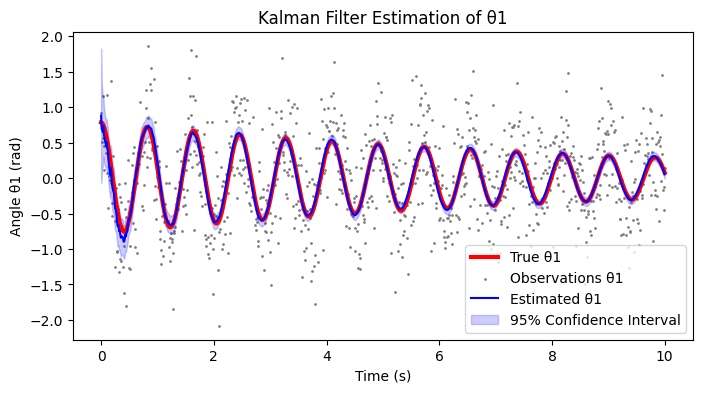

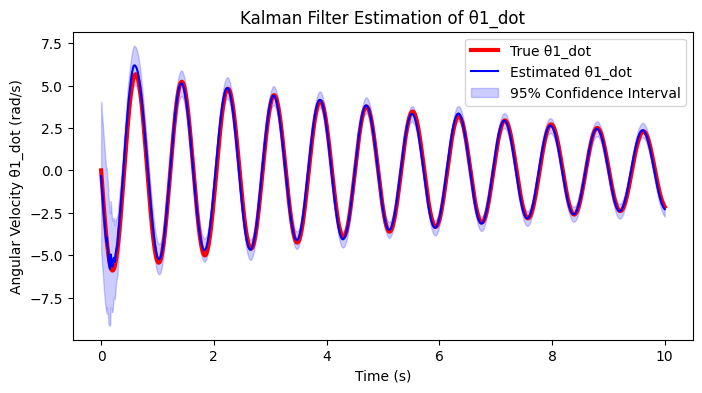

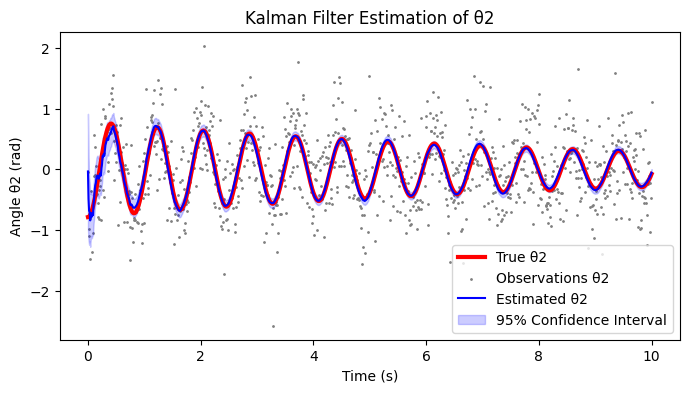

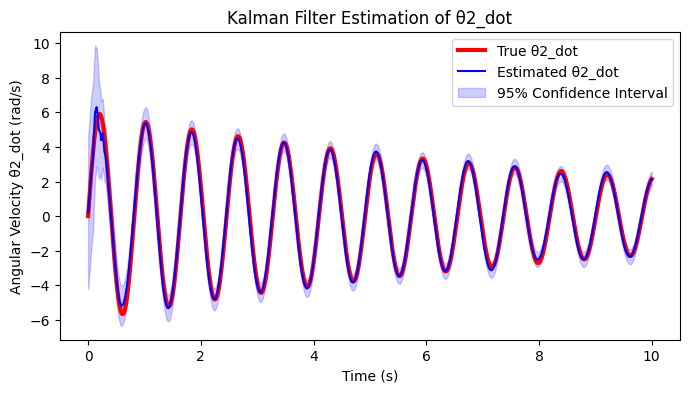

In [26]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt


initial_angle1 = 45
initial_angle2 = -45
t1_0 = initial_angle1 * (jnp.pi / 180)
t2_0 = initial_angle2 * (jnp.pi / 180)
td1_0 = 0
td2_0 = 0


g = 9.81
l = 0.5
m = 1
lam = 0.2

T = 10
dt = 0.01
N = int(T / dt)

sigma = 0.5    # observation noise standard deviation
q = 0      # process noise variance
R = sigma ** 2 * jnp.eye(2)

A = jnp.array([
    [0, 1, 0, 0],
    [-2 * (g / l), -lam / m, (g / l), 0],
    [0, 0, 0, 1],
    [(g / l), 0, -2 * (g / l), -lam / m]
])

I = jnp.eye(4)
F = I + A * dt

Q = q * dt * jnp.array([
    [0., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 0., 0.],
    [0., 0., 0., 1.]
])

C = jnp.array([
    [1., 0., 0., 0.],
    [0., 0., 1., 0.]
])

x0 = jnp.array([t1_0, td1_0, t2_0, td2_0])

key = random.PRNGKey(0)
key, subkey = random.split(key)
delta_beta1 = random.normal(subkey, shape=(N,)) * jnp.sqrt(q * dt)
key, subkey = random.split(key)
delta_beta2 = random.normal(subkey, shape=(N,)) * jnp.sqrt(q * dt)

w = jnp.stack([
    jnp.zeros(N),
    delta_beta1,
    jnp.zeros(N),
    delta_beta2
], axis=1)

key, subkey = random.split(key)
v = random.normal(subkey, shape=(N + 1, 2)) * sigma

def dynamics(x):
    return A @ x

def rk4_step(x, dt):
    k1 = dynamics(x)
    k2 = dynamics(x + 0.5 * dt * k1)
    k3 = dynamics(x + 0.5 * dt * k2)
    k4 = dynamics(x + dt * k3)
    return x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def step(x_prev, inputs):
    w_k, v_k = inputs
    x_k = rk4_step(x_prev, dt) + w_k
    y_k = C @ x_k + v_k
    return x_k, (x_k, y_k)

inputs = (w, v[1:])
x_last, (x_states, y_obs) = jax.lax.scan(step, x0, inputs)

x_full = jnp.vstack([x0, x_states])
y_full = jnp.vstack([C @ x0 + v[0], y_obs])

"""Kalman Filter"""

x_est_0 = jnp.array([0., 0., 0., 0.])
P0 = jnp.diag(jnp.array([5., 5., 5., 5.]))

def kalman_step(carry, y_k):
    x_est_prev, P_prev = carry

    x_pred = rk4_step(x_est_prev, dt)  # using RK4 in prediction step now
    P_pred = F @ P_prev @ F.T + Q

    y_pred = C @ x_pred
    e = y_k - y_pred
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T @ jnp.linalg.inv(S)
    x_est = x_pred + K @ e
    P_est = (jnp.eye(4) - K @ C) @ P_pred
    return (x_est, P_est), (x_est, P_est)

inputs = y_full
carry = (x_est_0, P0)
carry, outputs = jax.lax.scan(kalman_step, carry, inputs)

x_estimates = jnp.vstack([x_est_0, outputs[0]])
P_estimates = jnp.stack([P0] + [P for P in outputs[1]])

time = jnp.linspace(0, T, N+1)


theta1_est = x_estimates[:, 0]
theta1_true = x_full[:, 0]
theta1_std = jnp.sqrt(P_estimates[:, 0, 0])
theta1_upper = theta1_est + 1.96 * theta1_std
theta1_lower = theta1_est - 1.96 * theta1_std

theta1_dot_est = x_estimates[:, 1]
theta1_dot_true = x_full[:, 1]
theta1_dot_std = jnp.sqrt(P_estimates[:, 1, 1])
theta1_dot_upper = theta1_dot_est + 1.96 * theta1_dot_std
theta1_dot_lower = theta1_dot_est - 1.96 * theta1_dot_std

theta2_est = x_estimates[:, 2]
theta2_true = x_full[:, 2]
theta2_std = jnp.sqrt(P_estimates[:, 2, 2])
theta2_upper = theta2_est + 1.96 * theta2_std
theta2_lower = theta2_est - 1.96 * theta2_std

theta2_dot_est = x_estimates[:, 3]
theta2_dot_true = x_full[:, 3]
theta2_dot_std = jnp.sqrt(P_estimates[:, 3, 3])
theta2_dot_upper = theta2_dot_est + 1.96 * theta2_dot_std
theta2_dot_lower = theta2_dot_est - 1.96 * theta2_dot_std


plt.figure(figsize=(8, 4))
plt.plot(time, theta1_true, label='True θ1', color='red', linewidth=3)
plt.scatter(time, y_full[:, 0], s=1, label='Observations θ1', color='grey')
plt.plot(time, theta1_est[1:], label='Estimated θ1', color='blue')
plt.fill_between(time, theta1_lower[1:], theta1_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ1 (rad)')
plt.title('Kalman Filter Estimation of θ1')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time, theta1_dot_true, label='True θ1_dot', color='red', linewidth=3)
plt.plot(time, theta1_dot_est[1:], label='Estimated θ1_dot', color='blue')
plt.fill_between(time, theta1_dot_lower[1:], theta1_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity θ1_dot (rad/s)')
plt.title('Kalman Filter Estimation of θ1_dot')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time, theta2_true, label='True θ2', color='red', linewidth=3)
plt.scatter(time, y_full[:, 1], s=1, label='Observations θ2', color='grey')
plt.plot(time, theta2_est[1:], label='Estimated θ2', color='blue')
plt.fill_between(time, theta2_lower[1:], theta2_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ2 (rad)')
plt.title('Kalman Filter Estimation of θ2')
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(time, theta2_dot_true, label='True θ2_dot', color='red', linewidth=3)
plt.plot(time, theta2_dot_est[1:], label='Estimated θ2_dot', color='blue')
plt.fill_between(time, theta2_dot_lower[1:], theta2_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity θ2_dot (rad/s)')
plt.title('Kalman Filter Estimation of θ2_dot')
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from IPython.display import HTML

l1 = l2 = l

theta1_true_np = np.array(theta1_true)
theta1_est_np = np.array(theta1_est)
theta1_std_np = np.array(theta1_std)

theta2_true_np = np.array(theta2_true)
theta2_est_np = np.array(theta2_est)
theta2_std_np = np.array(theta2_std)

time_anim = np.array(time)

x1_true = l1 * np.sin(theta1_true_np)
y1_true = -l1 * np.cos(theta1_true_np)

x2_true = x1_true + l2 * np.sin(theta2_true_np)
y2_true = y1_true - l2 * np.cos(theta2_true_np)

x1_est = l1 * np.sin(theta1_est_np)
y1_est = -l1 * np.cos(theta1_est_np)

x2_est = x1_est + l2 * np.sin(theta2_est_np)
y2_est = y1_est - l2 * np.cos(theta2_est_np)

theta1_upper = theta1_est_np + 1.96 * theta1_std_np
theta1_lower = theta1_est_np - 1.96 * theta1_std_np

theta2_upper = theta2_est_np + 1.96 * theta2_std_np
theta2_lower = theta2_est_np - 1.96 * theta2_std_np

x1_upper = l1 * np.sin(theta1_upper)
y1_upper = -l1 * np.cos(theta1_upper)

x1_lower = l1 * np.sin(theta1_lower)
y1_lower = -l1 * np.cos(theta1_lower)

x2_upper = x1_upper + l2 * np.sin(theta2_upper)
y2_upper = y1_upper - l2 * np.cos(theta2_upper)

x2_lower = x1_lower + l2 * np.sin(theta2_lower)
y2_lower = y1_lower - l2 * np.cos(theta2_lower)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.grid(False)

line_true, = ax.plot([], [], 'o-', lw=2, color='green', label='True Pendulum')
line_est, = ax.plot([], [], 'o-', lw=2, color='blue', label='Estimated Pendulum')

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

confidence_patch = None

confidence_proxy = Patch(facecolor='blue', edgecolor='none', alpha=0.1,
                         label='95% Confidence Interval')

ax.legend(handles=[line_true, line_est, confidence_proxy], loc='upper right')

n = 4
frames = range(0, len(time_anim), n)

def init():
    global confidence_patch
    line_true.set_data([], [])
    line_est.set_data([], [])
    if confidence_patch is not None:
        confidence_patch.remove()
        confidence_patch = None
    time_text.set_text('')
    return line_true, line_est, time_text

def animate(i):
    global confidence_patch
    idx = frames[i]

    line_true.set_data(
        [0, x1_true[idx], x2_true[idx]],
        [0, y1_true[idx], y2_true[idx]]
    )

    line_est.set_data(
        [0, x1_est[idx], x2_est[idx]],
        [0, y1_est[idx], y2_est[idx]]
    )

    if confidence_patch is not None:
        confidence_patch.remove()
    x_confidence = [0, x1_upper[idx], x2_upper[idx],
                    x2_lower[idx], x1_lower[idx]]
    y_confidence = [0, y1_upper[idx], y2_upper[idx],
                    y2_lower[idx], y1_lower[idx]]
    confidence_patch = ax.fill(x_confidence, y_confidence, color='blue',
                               alpha=0.1)[0]

    time_text.set_text(f'Time = {time_anim[idx]:.2f} s')
    return line_true, line_est, confidence_patch, time_text

ani = FuncAnimation(fig, animate, frames=len(frames),
                    interval=dt*1000*n, blit=True, init_func=init)

plt.close(fig)
HTML(ani.to_jshtml())


ani.save('double_pendulum_simulation_lin_rk4.mp4', writer='ffmpeg', fps=25)

files.download('double_pendulum_simulation_lin_rk4.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

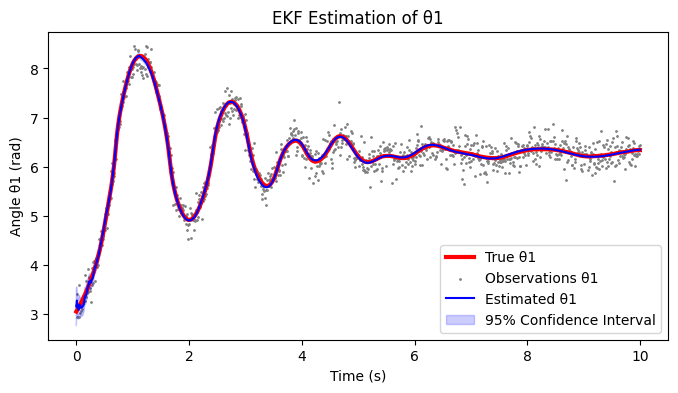

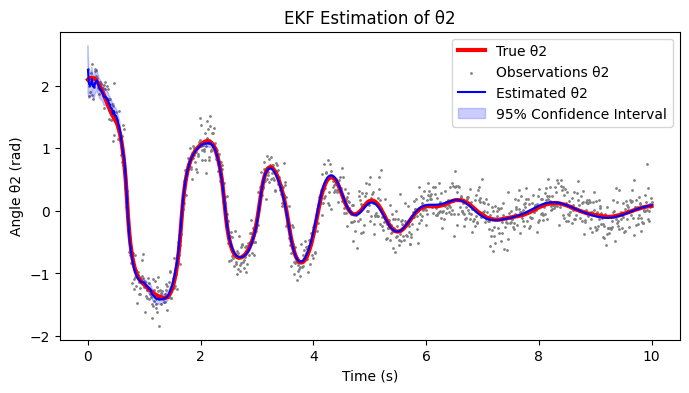

In [28]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt


initial_angle1 = 175
initial_angle2 = 120
t1_0 = initial_angle1 * (jnp.pi / 180)
t2_0 = initial_angle2 * (jnp.pi / 180)
td1_0 = 2
td2_0 = 1


g = 9.81
m1 = 1.0
m2 = 1.0
l1 = 0.5
l2 = 0.5
lam = 0.2

T = 10
dt = 0.01
N = int(T / dt)


sigma = 0.2    # observation noise standard deviation
q = 0.0001     # process noise variance
R = sigma ** 2 * jnp.eye(2)


C = jnp.array([
    [1., 0., 0., 0.],
    [0., 0., 1., 0.]
])


x0 = jnp.array([t1_0, td1_0, t2_0, td2_0])

def dynamics(state):

    theta1, theta1_dot, theta2, theta2_dot = state

    cos_d = jnp.cos(theta1 - theta2)
    sin_d = jnp.sin(theta1 - theta2)

    m11 = (m1 + m2) * l1**2
    m12 = m2 * l1 * l2 * cos_d
    m22 = m2 * l2**2

    f1 = -m2 * l1 * l2 * sin_d * theta2_dot**2 - (m1 + m2) * g * l1 * jnp.sin(theta1) - lam * theta1_dot
    f2 = m2 * l1 * l2 * sin_d * theta1_dot**2 - m2 * g * l2 * jnp.sin(theta2) - lam * theta2_dot

    det = m11 * m22 - m12 * m12

    theta1_ddot = (m22 * f1 - m12 * f2) / det
    theta2_ddot = (-m12 * f1 + m11 * f2) / det

    return jnp.array([
        theta1_dot,
        theta1_ddot,
        theta2_dot,
        theta2_ddot
    ])

def rk4_step(x, dt):
    k1 = dynamics(x)
    k2 = dynamics(x + 0.5 * dt * k1)
    k3 = dynamics(x + 0.5 * dt * k2)
    k4 = dynamics(x + dt * k3)
    return x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

key = random.PRNGKey(0)
key, subkey = random.split(key)
w = random.normal(subkey, shape=(N, 4)) * jnp.sqrt(q * dt)
key, subkey = random.split(key)
v = random.normal(subkey, shape=(N + 1, 2)) * sigma

def step(x_prev, inputs):
    w_k, v_k = inputs
    x_k = rk4_step(x_prev, dt) + w_k
    y_k = C @ x_k + v_k
    return x_k, (x_k, y_k)

inputs = (w, v[1:])
x_last, (x_states, y_obs) = jax.lax.scan(step, x0, inputs)

x_full = jnp.vstack([x0, x_states])
y_full = jnp.vstack([C @ x0 + v[0], y_obs])


def get_jacobian(x):
    """Compute the Jacobian of the dynamics at state x"""
    return jax.jacfwd(dynamics)(x)

x_est_0 = jnp.array([0., 0., 0., 0.])
P0 = jnp.diag(jnp.array([5., 5., 5., 5.]))

def ekf_step(carry, y_k):
    x_est_prev, P_prev = carry

    x_pred = rk4_step(x_est_prev, dt)
    F = jnp.eye(4) + get_jacobian(x_est_prev) * dt  # linearse around current estimate - forward euler
    P_pred = F @ P_prev @ F.T + Q

    y_pred = C @ x_pred
    e = y_k - y_pred
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T @ jnp.linalg.inv(S)
    x_est = x_pred + K @ e
    P_est = (jnp.eye(4) - K @ C) @ P_pred

    return (x_est, P_est), (x_est, P_est)


Q = q * dt * jnp.array([
    [0., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 0., 0.],
    [0., 0., 0., 1.]
])


inputs = y_full
carry = (x_est_0, P0)
carry, outputs = jax.lax.scan(ekf_step, carry, inputs)

x_estimates = jnp.vstack([x_est_0, outputs[0]])
P_estimates = jnp.stack([P0] + [P for P in outputs[1]])


time = jnp.linspace(0, T, N+1)

theta1_est = x_estimates[:, 0]
theta1_true = x_full[:, 0]
theta1_std = jnp.sqrt(P_estimates[:, 0, 0])
theta1_upper = theta1_est + 1.96 * theta1_std
theta1_lower = theta1_est - 1.96 * theta1_std

theta2_est = x_estimates[:, 2]
theta2_true = x_full[:, 2]
theta2_std = jnp.sqrt(P_estimates[:, 2, 2])
theta2_upper = theta2_est + 1.96 * theta2_std
theta2_lower = theta2_est - 1.96 * theta2_std

plt.figure(figsize=(8, 4))
plt.plot(time, theta1_true, label='True θ1', color='red', linewidth=3)
plt.scatter(time, y_full[:, 0], s=1, label='Observations θ1', color='grey')
plt.plot(time, theta1_est[1:], label='Estimated θ1', color='blue')
plt.fill_between(time, theta1_lower[1:], theta1_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ1 (rad)')
plt.title('EKF Estimation of θ1')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time, theta2_true, label='True θ2', color='red', linewidth=3)
plt.scatter(time, y_full[:, 1], s=1, label='Observations θ2', color='grey')
plt.plot(time, theta2_est[1:], label='Estimated θ2', color='blue')
plt.fill_between(time, theta2_lower[1:], theta2_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle θ2 (rad)')
plt.title('EKF Estimation of θ2')
plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from IPython.display import HTML



theta1_true_np = np.array(theta1_true)
theta1_est_np = np.array(theta1_est)
theta1_std_np = np.array(theta1_std)

theta2_true_np = np.array(theta2_true)
theta2_est_np = np.array(theta2_est)
theta2_std_np = np.array(theta2_std)

time_anim = np.array(time)

x1_true = l1 * np.sin(theta1_true_np)
y1_true = -l1 * np.cos(theta1_true_np)

x2_true = x1_true + l2 * np.sin(theta2_true_np)
y2_true = y1_true - l2 * np.cos(theta2_true_np)

x1_est = l1 * np.sin(theta1_est_np)
y1_est = -l1 * np.cos(theta1_est_np)

x2_est = x1_est + l2 * np.sin(theta2_est_np)
y2_est = y1_est - l2 * np.cos(theta2_est_np)

theta1_upper = theta1_est_np + 1.96 * theta1_std_np
theta1_lower = theta1_est_np - 1.96 * theta1_std_np

theta2_upper = theta2_est_np + 1.96 * theta2_std_np
theta2_lower = theta2_est_np - 1.96 * theta2_std_np

x1_upper = l1 * np.sin(theta1_upper)
y1_upper = -l1 * np.cos(theta1_upper)

x1_lower = l1 * np.sin(theta1_lower)
y1_lower = -l1 * np.cos(theta1_lower)

x2_upper = x1_upper + l2 * np.sin(theta2_upper)
y2_upper = y1_upper - l2 * np.cos(theta2_upper)

x2_lower = x1_lower + l2 * np.sin(theta2_lower)
y2_lower = y1_lower - l2 * np.cos(theta2_lower)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
ax.grid(False)

line_true, = ax.plot([], [], 'o-', lw=2, color='green', label='True Pendulum')
line_est, = ax.plot([], [], 'o-', lw=2, color='blue', label='Estimated Pendulum')

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

confidence_patch = None

confidence_proxy = Patch(facecolor='blue', edgecolor='none', alpha=0.1,
                         label='95% Confidence Interval')

ax.legend(handles=[line_true, line_est, confidence_proxy], loc='upper right')

n = 4
frames = range(0, len(time_anim), n)

def init():
    global confidence_patch
    line_true.set_data([], [])
    line_est.set_data([], [])
    if confidence_patch is not None:
        confidence_patch.remove()
        confidence_patch = None
    time_text.set_text('')
    return line_true, line_est, time_text

def animate(i):
    global confidence_patch
    idx = frames[i]

    line_true.set_data(
        [0, x1_true[idx], x2_true[idx]],
        [0, y1_true[idx], y2_true[idx]]
    )

    line_est.set_data(
        [0, x1_est[idx], x2_est[idx]],
        [0, y1_est[idx], y2_est[idx]]
    )

    if confidence_patch is not None:
        confidence_patch.remove()
    x_confidence = [0, x1_upper[idx], x2_upper[idx],
                    x2_lower[idx], x1_lower[idx]]
    y_confidence = [0, y1_upper[idx], y2_upper[idx],
                    y2_lower[idx], y1_lower[idx]]
    confidence_patch = ax.fill(x_confidence, y_confidence, color='blue',
                               alpha=0.1)[0]

    time_text.set_text(f'Time = {time_anim[idx]:.2f} s')
    return line_true, line_est, confidence_patch, time_text

ani = FuncAnimation(fig, animate, frames=len(frames),
                    interval=dt*1000*n, blit=True, init_func=init)

plt.close(fig)
HTML(ani.to_jshtml())

ani.save('double_pendulum_simulation_nonlin_rk4.mp4', writer='ffmpeg', fps=25)

files.download('double_pendulum_simulation_nonlin_rk4.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>